# XAI (Explainable Artificial Intelligence) 

- 설명 가능한 인공지능, 도출 결과를 사람이 이해할 수 있도록 설명하는 방법론과 분야
- 의학 쪽에서 적극적으로 사용하고 있다. 

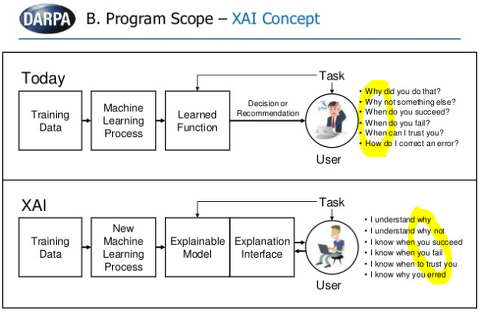

# SHAP, SAGE
- SHAP : 각 피저들이 개별 예측에 얼마나 기여를 했는가? (중요)
- SAGE : 모델 학습시 각 피처들에 얼마나 의존했는가? 

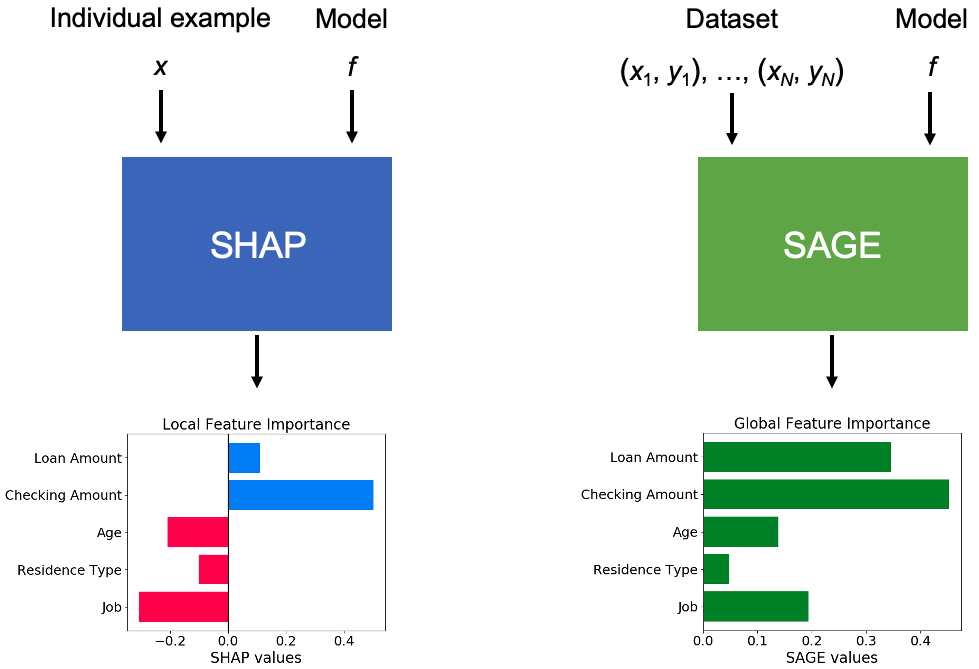

- SAGE는 모델이 학습할때 features 사용 정도를 표현하는데, 사용을 많이 했다는 것이 중요하다는 의미는 아니다.
- SHAP는 target을 예측할 때 각 feature들이 얼마나 많이 기여를 했는지 파악하기에 조금 더 정확하다. 

# 데이터 준비

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')
cols = ['age', 'sibsp', 'parch', 'fare']
features = df[cols]
target = df['survived']

인코딩

In [5]:
from sklearn.preprocessing import OneHotEncoder

cols = ['pclass', 'sex', 'embarked']

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features, tmp], axis=1)

In [6]:
features.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


결측치 제거

In [7]:
features.age = features.age.fillna(features.age.median())

데이터 스케일링

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = pd.DataFrame(
    scaler.fit_transform(features),
    columns = features.columns
)

데이터 분리

In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

In [11]:
random_state =42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    random_state = random_state
)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

# SAGE

학습

In [12]:
from lightgbm import LGBMClassifier, plot_importance

model = LGBMClassifier(random_state=random_state).fit(X_tr, y_tr)

평가

In [13]:
from sklearn.metrics import roc_auc_score

pred = model.predict_proba(X_te)[:, 1]
roc_auc_score(y_te, pred)

0.8806949806949808

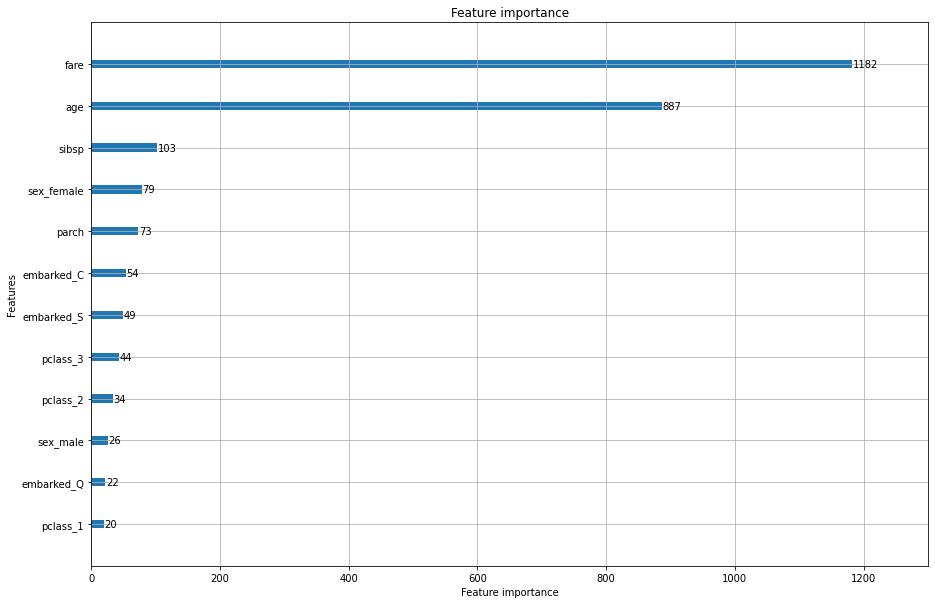

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
plot_importance(model, ax=ax)
plt.show()

# SHAP

In [16]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.6 MB/s eta 0:00:00


In [17]:
import shap

In [18]:
# 학습된 모델을 넣는다
explainer = shap.TreeExplainer(model) 

# 학습을 마친 상태에서 test data를 넣어준다. 에측했을때의 feature가 어떤 것이 많이 반영되었는지 파악하기 위해서. 
shap_values = explainer.shap_values(X_te) 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [20]:
shap_values[1].shape, X_te.shape

((179, 13), (179, 13))

force_plot

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][-1, :], X_te.iloc[-1, :])

summary_plot
- 가장 많이 사용하는 지표

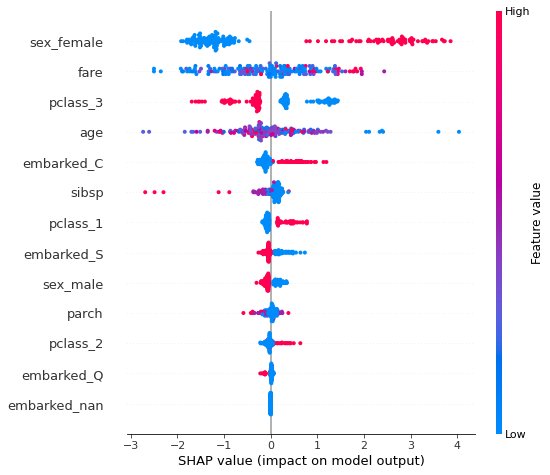

In [24]:
shap.summary_plot(shap_values[1],X_te)